#### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import tqdm

%matplotlib notebook

In [2]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Hyper-parameters 
num_epochs = 50
batch_size = 8
learning_rate = 0.001

#### Reading dataset

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# # Split the train dataset into train and validation sets
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size

# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


<IPython.core.display.Javascript object>


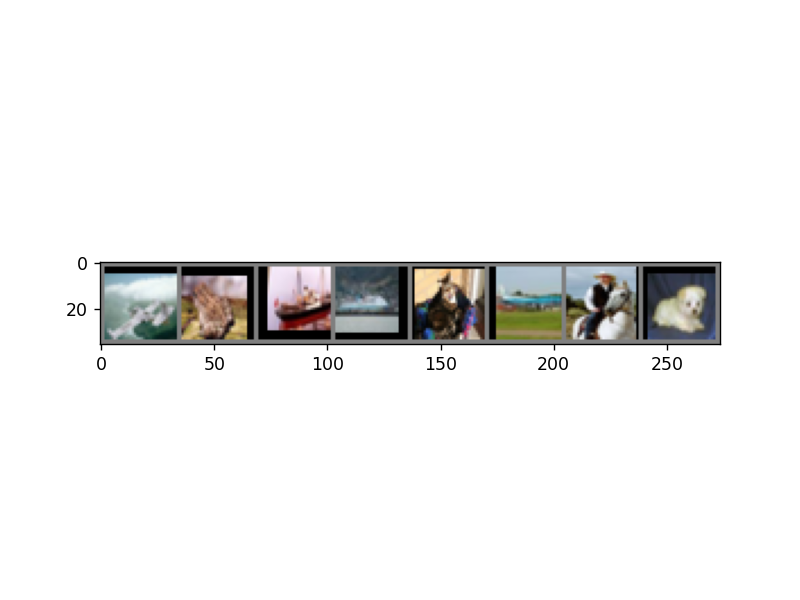

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
# # To determine the input size of fully connected layer

# conv1 = nn.Conv2d(3, 32, 3)
# pool1 = nn.MaxPool2d(2, 2)
# conv2 = nn.Conv2d(32, 64, 5)
# pool2 = nn.MaxPool2d(2,2)
# conv3 = nn.Conv2d(64,64,3)
# print(images.shape)
# y = conv1(images)
# print(y.shape)
# y = pool1(y)
# print(y.shape)
# y = conv2(y)
# print(y.shape)
# y = pool2(y)
# print(y.shape)
# y = conv3(y)
# print(y.shape)

#### Model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2,stride = 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.pool2 = nn.MaxPool2d(2, stride = 2)
        self.conv3 = nn.Conv2d(64,64,3)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        y = self.pool1(F.relu(self.conv1(x)))        
        y = self.pool2(F.relu(self.conv2(y)))
        y = F.relu(self.conv3(y))
        y = torch.flatten(y, 1)     # Flatten
        y = F.relu(self.fc1(y))
        y = self.fc2(y)
        
        return y

In [9]:
model = CNN().to(device)

In [10]:
# Loss Function
#-----------------------------------------------------
criterion = nn.CrossEntropyLoss()
# criterion = nn.KLDivLoss(reduction='batchmean')


# Optimizer
#-----------------------------------------------------
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler
#-----------------------------------------------------
# scheduler = ExponentialLR(optimizer, gamma = 0.1)
# scheduler = StepLR(optimizer, step_size = 4, gamma = 0.5)


#### Training

In [12]:
# Initialize variable to track loss and accuracies for each epochs
y_loss = {} 
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []
x_epoch = []

n_total_steps = len(train_loader)
dataset_sizes = {'train': len(train_loader), 'val': len(val_loader)}

# start
start = time.time()
for epoch in tqdm.tqdm(range(num_epochs)):
    for phase in ['train', 'val']:        
        running_loss = 0.0
        running_corrects = 0.0
        count = 0
        total = 0
        if(phase == 'train'):
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
        
                # Forward pass
                outputs = model(images)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # the class with the highest energy is what we choose as prediction        
                running_loss += loss.item()              
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()
        
            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total
#             if (i+1) % 20 == 0:
#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0 - epoch_acc)
#             scheduler.step()

            
        elif(phase == 'val'):
            for i, (images, labels) in enumerate(val_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # the class with the highest energy is what we choose as prediction
                running_loss += loss.item()              
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()               
                
            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total
#             if (i+1) % 200 == 0:
#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0 - epoch_acc)

            x_epoch.append(epoch)  
            
print(f'training time: {(time.time()-start)} sec')
# end

100%|██████████████████████████████████████████████████████████████| 50/50 [30:01<00:00, 36.02s/it]

training time: 1801.0793359279633 sec


#### Plot Curve

<IPython.core.display.Javascript object>


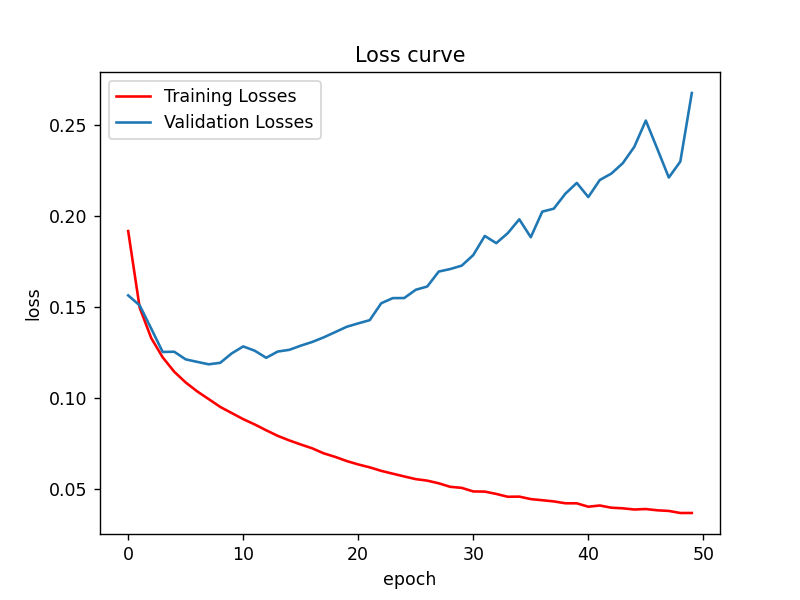

In [13]:
# Plot Loss curve
plt.plot(y_loss['train'], "-r", label = "Training Losses")
plt.plot(y_loss['val'], label = "Validation Losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss curve")
plt.legend()
plt.show()
plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"_Loss_sgd.png")

<IPython.core.display.Javascript object>


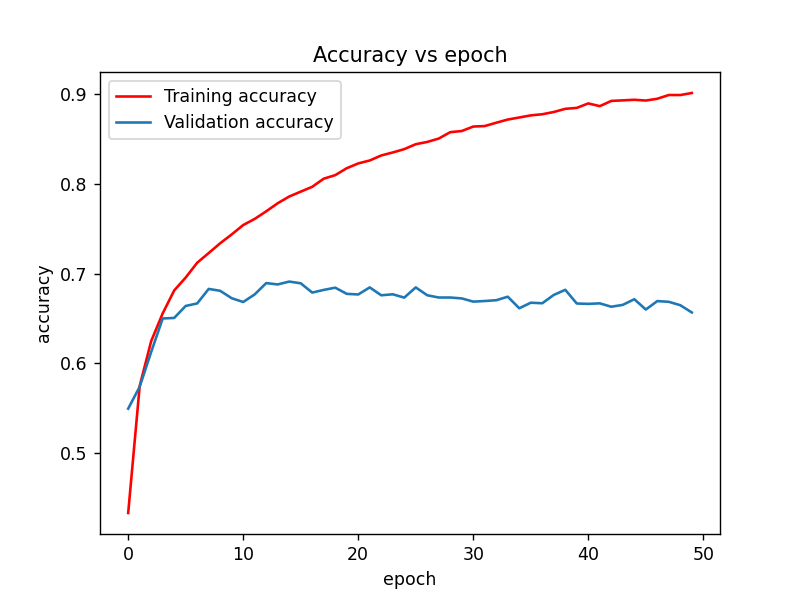

In [14]:
# Plot accuracy curve
plt.close()
plt.plot(1-np.array(y_err['train']), "-r", label = "Training accuracy")
plt.plot(1-np.array(y_err['val']), label = "Validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.show()
plt.savefig("./img/b"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"accuracy_sgd.png")

In [15]:
# save model
print('Finished Training')
PATH = "cnn_model"+str(batch_size)+"_lr"+str(learning_rate)+"_epoch"+str(num_epochs)+"sgd.pth"
torch.save(model.state_dict(), PATH)

Finished Training


#### Prediction and accuracies

In [16]:
# Calculate Train Accuracy
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 50000 train images: {100 * correct / total:.1f} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} \%\\\\')

Accuracy of the network on the 50000 train images: 89.9 %
Accuracy for class: plane is 91.8 \%\
Accuracy for class: car   is 96.3 \%\
Accuracy for class: bird  is 90.1 \%\
Accuracy for class: cat   is 80.9 \%\
Accuracy for class: deer  is 88.3 \%\
Accuracy for class: dog   is 78.2 \%\
Accuracy for class: frog  is 96.6 \%\
Accuracy for class: horse is 93.1 \%\
Accuracy for class: ship  is 96.0 \%\
Accuracy for class: truck is 88.0 \%\


In [17]:
# Calculate Validation Accuracy
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.1f} %')

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} \%\\\\')

Accuracy of the network on the 10000 test images: 65.7 %
Accuracy for class: plane is 69.5 \%\
Accuracy for class: car   is 80.6 \%\
Accuracy for class: bird  is 57.8 \%\
Accuracy for class: cat   is 45.1 \%\
Accuracy for class: deer  is 55.6 \%\
Accuracy for class: dog   is 49.0 \%\
Accuracy for class: frog  is 80.2 \%\
Accuracy for class: horse is 71.1 \%\
Accuracy for class: ship  is 78.5 \%\
Accuracy for class: truck is 69.1 \%\
